In [64]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

# ReplayBuffer

In [65]:
class ReplayBuffer:
    """ Experience replay buffer for storing transitions. """
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)

In [66]:
class Qnet(torch.nn.Module):
    """ Q-network with one hidden layer."""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# DQN Algorithm

In [67]:
class DQN:
    """ DQN Algorithm."""
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float32).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float32).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float32).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float32).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)

        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = F.mse_loss(q_values, q_targets)

        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

# CartPole-v0

In [51]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0
env_name = 'CartPole-v0'
env = gym.make(env_name)
env.reset(seed=seed)
env.action_space.seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            reset_output = env.reset()
            state = reset_output[0] if isinstance(reset_output, tuple) else reset_output
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward

                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'rewards': b_r,
                        'next_states': b_ns,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%d' % (np.mean(return_list[-10:]))
                })
            pbar.update(1)


Iteration 9: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s, episode=500, return=182]


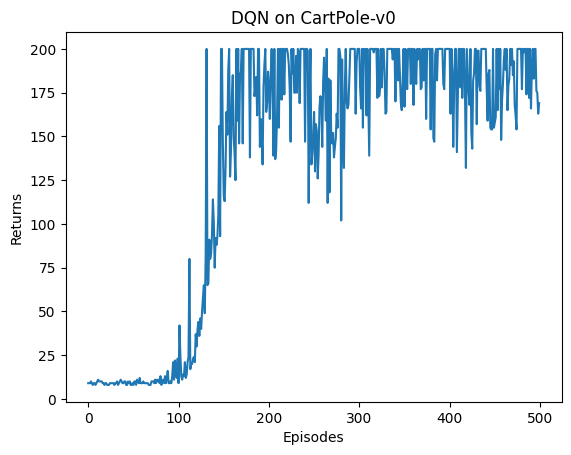

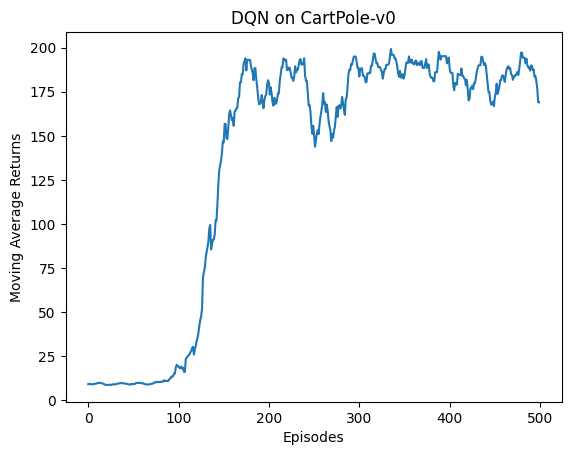

In [52]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on %s' % env_name)
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Moving Average Returns')
plt.title('DQN on %s' % env_name)
plt.show()

# DQN with Image Input

In [ ]:
class ConvolutionalQnet(torch.nn.Module):
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.head = nn.Linear(512, action_dim)
    
    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.relu(self.fc4(x))
        return self.head(x)

# CartPole-v1

In [68]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0
env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=seed)
env.action_space.seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            reset_output = env.reset()
            state = reset_output[0] if isinstance(reset_output, tuple) else reset_output
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward

                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'rewards': b_r,
                        'next_states': b_ns,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%d' % (np.mean(return_list[-10:]))
                })
            pbar.update(1)


Iteration 9: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s, episode=500, return=432]


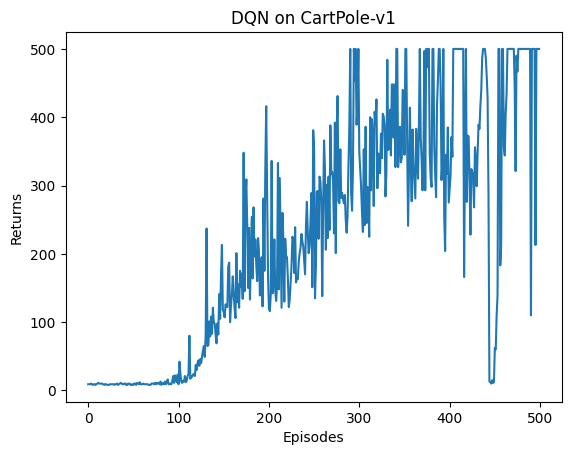

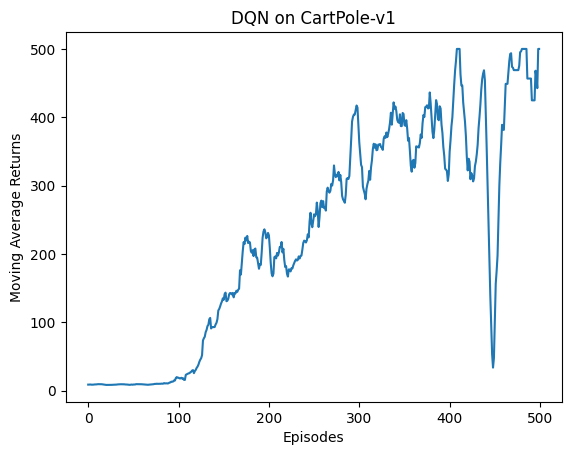

In [69]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on %s' % env_name)
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Moving Average Returns')
plt.title('DQN on %s' % env_name)
plt.show()

# GPT

In [55]:
class QNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.net(x)


In [61]:
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, lr, gamma, epsilon_start, epsilon_end, epsilon_decay, target_update, device):
        self.q_net = QNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_q_net = QNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.target_update = target_update
        self.device = device
        self.count = 0
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.action_dim = action_dim

    def take_action(self, state):
        epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                  np.exp(-1. * self.count / self.epsilon_decay)
        self.count += 1
        if np.random.random() < epsilon:
            return np.random.randint(self.action_dim)
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            return self.q_net(state).argmax().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float32).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float32).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float32).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float32).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        with torch.no_grad():
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
            q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)

        loss = F.mse_loss(q_values, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())


In [62]:
# ==== 环境和随机种子设定 ====
seed = 0
env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=seed)
env.observation_space.seed(seed)
env.action_space.seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# ==== 超参数 ====
lr = 1e-3                 # 学习率
num_episodes = 600        # 训练总回合数
hidden_dim = 128          # Q网络隐藏层大小
gamma = 0.99              # 折扣因子
epsilon_start = 0.3       # 初始探索率
epsilon_end = 0.01        # 最小探索率
epsilon_decay = 500       # 探索率衰减步数
target_update = 10        # target 网络更新频率
buffer_size = 10000       # 经验回放缓冲区大小
minimal_size = 1000       # 最小训练启动样本数
batch_size = 64           # batch 大小
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 构建 ReplayBuffer 和 Agent ====
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon_start, epsilon_end, epsilon_decay, target_update, device)

# ==== 训练主循环 ====
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                reward = np.clip(reward, -1.0, 1.0)  # reward clipping

                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward

                if replay_buffer.size() >= minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'rewards': b_r,
                        'next_states': b_ns,
                        'dones': b_d
                    }
                    agent.update(transition_dict)

            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%.1f' % (np.mean(return_list[-10:]))
                })
            pbar.update(1)


Iteration 0:   0%|          | 0/60 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 60/60 [00:16<00:00,  3.57it/s, episode=600, return=388.8]


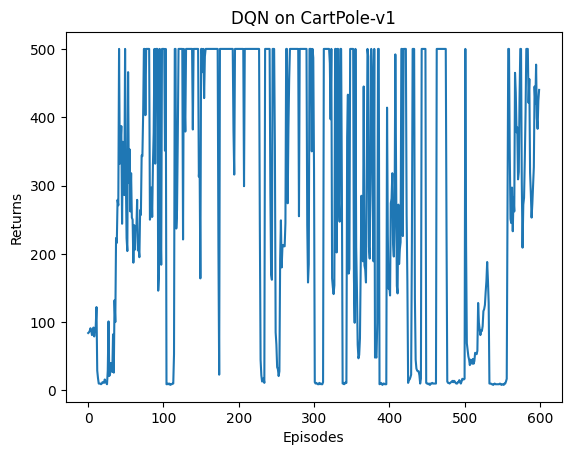

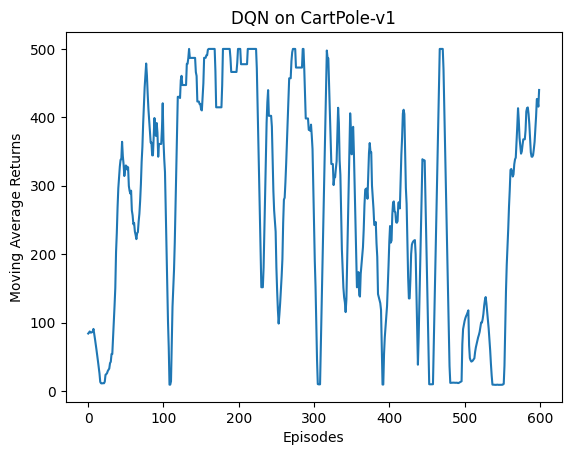

In [63]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on %s' % env_name)
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Moving Average Returns')
plt.title('DQN on %s' % env_name)
plt.show()